In [ ]:
#Load packages
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score
#from keras.utils import plot_model
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#This is important to make the results of logti results same everytime
np.random.seed(12)

In [ ]:
#set all the columns we be viewed
pd.set_option('display.max_columns', None)
% matplotlib inline

In [ ]:
#read the raw data from NCCS
df = pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/df_7k.csv')

In [ ]:
# Select needed columns
df=df[['ein','Org Name','label']]

In [ ]:
#reset index
#df = df.sample(frac=1).reset_index(drop=True)
df = df.reset_index(drop=True)

In [ ]:
df

,ein,Org Name,label
0,753096568,SMST SOCIETY INC,0
1,42614817,Portuguese National Club Inc,1
2,942378900,ST PAUL MISSIONARY BAPTIST CHURCH,0
3,521324875,HARTWOOD GROUP HOMES INCORPORATED,0
4,770227659,ACT FOR MENTAL HEALTH,0
...,...,...,...
6022,61669649,Northwest Employment Education and Defense Fund,1
6023,912138852,East African Community Services,1
6024,942775529,CENTRO EVANGELISTICO MISIONERO,1
6025,465328798,SPANISH UNITED PENTECOSTAL CHURCH,0


In [ ]:
# need to add some legal aid orgs since they provide immigrantion service but were not covered
legal = pd.DataFrame.from_dict({'CALIFORNIA RURAL LEGAL ASSISTANCE, INC.','Global Family Legal Services (Tucson Office)','Florence Immigrant and Refugee Rights Project',
'Pangea Legal Services', 'International Rescue Committee'})
legal.columns = ['Org Name']

In [ ]:

legal['ein']= 999
legal['label']= 1

In [ ]:
legal = legal[['ein','Org Name','label']]

In [ ]:
# append extra legal orgs
df = df.append(legal)

In [ ]:
#df = df.sample(frac=1).reset_index(drop=True)
#reset index
df = df.reset_index(drop=True)

In [ ]:
#read validation dataset 
df_val= pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/hold_out.csv')
#df_val= pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/df_img_bay.csv', encoding='latin-1')

In [ ]:
#df_val=df_val[['EIN','NAME']]
#df_val.columns = ['code','name']
#df_val = df_val.sample(frac=1).reset_index(drop=True)

# Data Preprocessing and Exploration

In [ ]:
df.shape

(6032, 3)

In [ ]:
#missing rate of each column in df 
df.isna().sum()/len(df)*100

ein         0.0
Org Name    0.0
label       0.0
dtype: float64

In [ ]:
#Training ---- label/target classification distrubtion 
df.label.value_counts()/df.shape[0]

0    0.562334
1    0.437666
Name: label, dtype: float64

In [ ]:
#Test ---- label/target classification distrubtion 
df_val.label.value_counts()/df_val.shape[0]

1    0.5
0    0.5
Name: label, dtype: float64

In [ ]:
df.tail()

,ein,Org Name,label
6027,202798922,Families for Freedom Inc,1
6028,133336640,National Lawyers Guild Foundation,1
6029,813746832,Haitian Hope Inc,1
6030,943204584,MOUNTAIN VIEW SOFTBALL INC A DELAWARE CORP,0
6031,461948559,NORTHWEST GEORGIA EMS SYSTEMS INC,0


In [ ]:
df_val=df_val[['ein','Org Name','label']]

### Text Cleaning

Clean the text and extract some useful information from the text so we can do some data analysis to see the difference between 

In [ ]:
#Combine org names for data cleaning
df['org_val'] = 'org'
df_val['org_val'] = 'val'
combined  = df.append(df_val)

In [ ]:
combined.reset_index(drop=True)

,ein,Org Name,label,org_val
0,472937345,Concilio Evangelistico Internacional Cristo Vi...,1,org
1,453811463,Sierra Vista Budhist Temple,1,org
2,770570323,SILICON VALLEY AI-YUE CHORUS,1,org
3,770049554,KAISAHAN OF SAN JOSE,1,org
4,770080680,USPC NEWCO INC,0,org
...,...,...,...,...
6427,50564361,VISIONS FOR TEENS AT RISK INC,0,val
6428,776154815,VISHAV GURMAT ROOHANI MISSION CHARITABLE TRUST,1,val
6429,770513491,INTERNATIONAL BUDDHIST SAM BO JONG USA INC,1,val
6430,943300872,NORTHERN CALIFORNIA SOAP BOX DERBY INC,0,val


In [ ]:
#len of characters(letter)
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
combined['num_char'] =  combined['Org Name'].apply(lambda x: count(x, string.ascii_letters))

In [ ]:
combined.head()

,ein,Org Name,label,org_val,num_char
0,472937345,Concilio Evangelistico Internacional Cristo Vi...,1,org,48
1,453811463,Sierra Vista Budhist Temple,1,org,24
2,770570323,SILICON VALLEY AI-YUE CHORUS,1,org,24
3,770049554,KAISAHAN OF SAN JOSE,1,org,17
4,770080680,USPC NEWCO INC,0,org,12


In [ ]:
combined.describe()

,ein,label,num_char
count,6.432000e+03,6432.000000,6432.000000
mean,6.034604e+08,0.441542,28.845305
std,2.853698e+08,0.496610,11.036750
min,9.990000e+02,0.000000,0.000000
25%,3.310598e+08,0.000000,21.000000
50%,7.529770e+08,0.000000,28.000000
75%,8.139219e+08,1.000000,35.000000
max,9.950080e+08,1.000000,85.000000


In [ ]:
#function to clean the text
def clean_text(txt):

  # remove URL
  url = re.compile(r'https?://\S+|www\.\S+')
  txt = url.sub(r'', txt)

  # remove html
  html = re.compile(r'<.*?>')
  txt = html.sub(r'',txt)

  alpha_pattern = re.compile(r'\b[^\d\W][^\d\W]+\b')
  
  # remove stopwords 
  lst_txt = [w.lower() for w in word_tokenize(txt) if w not in stopwords.words('english')]
  lst_txt = [''.join(alpha_pattern.findall(w)) for w in lst_txt]

  return ' '.join(lst_txt)

In [ ]:
#get the clean text
combined['cleaned_text'] = combined['Org Name'].apply(lambda x: clean_text(x))
df['cleaned_text'] = df['Org Name'].apply(lambda x: clean_text(x))
df_val['cleaned_text'] = df_val['Org Name'].apply(lambda x: clean_text(x))

In [ ]:
combined.head()

,ein,Org Name,label,org_val,num_char,cleaned_text
0,472937345,Concilio Evangelistico Internacional Cristo Vi...,1,org,48,concilio evangelistico internacional cristo vi...
1,453811463,Sierra Vista Budhist Temple,1,org,24,sierra vista budhist temple
2,770570323,SILICON VALLEY AI-YUE CHORUS,1,org,24,silicon valley aiyue chorus
3,770049554,KAISAHAN OF SAN JOSE,1,org,17,kaisahan of san jose
4,770080680,USPC NEWCO INC,0,org,12,uspc newco inc


In [ ]:
# Call the stemmer
def stem(txt):
  porter = PorterStemmer()
  lst = [porter.stem(w) for w in txt.split()]
  return (' '.join(lst))

combined['stem'] = combined['cleaned_text'].apply(lambda x: stem(x))

In [ ]:
combined.head()

,ein,Org Name,label,org_val,num_char,cleaned_text,stem
0,472937345,Concilio Evangelistico Internacional Cristo Vi...,1,org,48,concilio evangelistico internacional cristo vi...,concilio evangelistico internacion cristo vive...
1,453811463,Sierra Vista Budhist Temple,1,org,24,sierra vista budhist temple,sierra vista budhist templ
2,770570323,SILICON VALLEY AI-YUE CHORUS,1,org,24,silicon valley aiyue chorus,silicon valley aiyu choru
3,770049554,KAISAHAN OF SAN JOSE,1,org,17,kaisahan of san jose,kaisahan of san jose
4,770080680,USPC NEWCO INC,0,org,12,uspc newco inc,uspc newco inc


In [ ]:
combined.reset_index(inplace=True, drop=True)

## EDA

#### Features in text

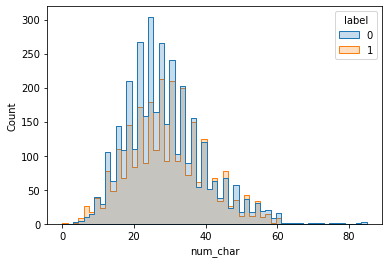

In [ ]:
sns.histplot(combined, x="num_char", hue="label", element="step")

# Modeling

In [ ]:
#create a function to print metrics at once
def model_result(model, x_train, x_test, y_train, y_test):
  y_pred_train= model.predict(x_train)
  y_pred_test = model.predict(x_test)
  print('train')
  print(confusion_matrix(y_train, y_pred_train))
  print('accuracy is {0:.4f}'.format(accuracy_score(y_train, y_pred_train)))
  print('recall is {0:.4f}'.format(recall_score(y_train, y_pred_train)))
  print('f1 score is {0:.4f}'.format(f1_score(y_train, y_pred_train)))
  print('---------------')
  print('test')
  print(confusion_matrix(y_test, y_pred_test))
  print('accuracy is {0:.4f}'.format(accuracy_score(y_test, y_pred_test)))
  print('recall is {0:.4f}'.format(recall_score(y_test, y_pred_test)))
  print('f1 score is {0:.4f}'.format(f1_score(y_test, y_pred_test)))

## Frequency Based

### Bag of words

In [ ]:
#bag of words
my_pattern = r'\b[^\d\W][^\d\W]+\b' #simply match a word, specificly choose the words by no digits or no alphanumberic&underscore on the boundary
vect_c= CountVectorizer(ngram_range=(1,3), 
                        max_features=6000, # this can be tuned further
                        token_pattern=my_pattern, 
                        strip_accents = 'ascii', #take out non ascii characters
                        stop_words = 'english').fit(combined['stem']) # nltk and sklearn has different stopwords sets
txt_c= vect_c.transform(combined['stem'])

In [ ]:
X_txt_c=pd.DataFrame(txt_c.toarray(), columns=vect_c.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_txt_c.head()

abierta  abl  abund  abus  abus prevent  academ  academi  academi chines  \
0        0    0      0     0             0       0        0               0   
1        0    0      0     0             0       0        0               0   
2        0    0      0     0             0       0        0               0   
3        0    0      0     0             0       0        0               0   
4        0    0      0     0             0       0        0               0   

   access  access corpor  account  ace  ace mentor  achiev  acr  act  action  \
0       0              0        0    0           0       0    0    0       0   
1       0              0        0    0           0       0    0    0       0   
2       0              0        0    0           0       0    0    0       0   
3       0              0        0    0           0       0    0    0       0   
4       0              0        0    0           0       0    0    0       0   

   action fund  action network  action resourc  activ  activ leagu  actor  \
0            0               0               0      0            0      0   
1            0               0               0      0            0      0   
2            0               0               0      0            0      0   
3            0               0               0      0            0      0   
4            0               0               0      0            0      0   

   adam  addict  addict recoveri  adelant  adopt  adult  adult day  \
0     0       0                0        0      0      0          0   
1     0       0                0        0      0      0          0   
2     0       0                0        0      0      0          0   
3     0       0                0        0      0      0          0   
4     0       0                0        0      0      0          0   

   adult literaci  advanc  advanc justic  adventur  advisori  advisori board  \
0               0       0              0         0         0               0   
1               0       0              0         0         0               0   
2               0       0              0         0         0               0   
3               0       0              0         0         0               0   
4               0       0              0         0         0               0   

   advisori committe  advisori council  advoc  advocaci  advocaci center  \
0                  0                 0      0         0                0   
1                  0                 0      0         0                0   
2                  0                 0      0         0                0   
3                  0                 0      0         0                0   
4                  0                 0      0         0                0   

   advocaci project  aeronaut  aerospac  affair  affili  affili organ  afford  \
0                 0         0         0       0       0             0       0   
1                 0         0         0       0       0             0       0   
2                 0         0         0       0       0             0       0   
3                 0         0         0       0       0             0       0   
4                 0         0         0       0       0             0       0   

   afford hous  afghan  africa  african  african american  \
0            0       0       0        0                 0   
1            0       0       0        0                 0   
2            0       0       0        0                 0   
3            0       0       0        0                 0   
4            0       0       0        0                 0   

   african american commun  african assist  african commun  \
0                        0               0               0   
1                        0               0               0   
2                        0               0               0   
3                        0               0               0   
4                        0               0               0   

In [ ]:
#train test split
X = X_txt_c.iloc[0:6032,:]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


#### Logistic Regression

In [ ]:
#basic classification model
#log_model = LogisticRegression()
log_reg = LogisticRegression(max_iter= 500,random_state=12).fit(X_train,y_train)
model_result(log_reg, X_train, X_test, y_train, y_test)

train
[[2639   76]
 [ 367 1743]]
accuracy is 0.9082
recall is 0.8261
f1 score is 0.8872
---------------
test
[[605  72]
 [178 352]]
accuracy is 0.7929
recall is 0.6642
f1 score is 0.7379


In [ ]:
#cv = KFold(n_splits=10)
#cv.get_n_splits(X_train)
#for train_index, test_index in cv.split(X_train):
#  log_model = log_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
#  pred = log_model.predict(X_train.iloc[test_index,:])
#  acc_log = accuracy_score(y_train.iloc[test_index],pred)*100
#  print(acc_log)

In [ ]:
#model_result(log_model, X_train, X_test, y_train, y_test)

In [ ]:
accuracy_score(df_val['label'],log_reg.predict(X_txt_c.iloc[6032:,:])) #bag of words validation

0.7175

In [ ]:
confusion_matrix(df_val['label'],log_reg.predict(X_txt_c.iloc[6032:,:]))

array([[182,  18],
       [ 95, 105]])

In [ ]:
# Tuning 
log_grid = {'penalty': ['l2'],
            'C' : np.arange(0.1,1,0.2), 
            'solver': ['lbfgs']}
log_cv = RandomizedSearchCV(estimator = log_reg, 
                            random_state = 12,
                            param_distributions = log_grid, 
                            cv = 5) 
log_cv.fit(X_train, y_train)
log_tuned = log_cv.best_estimator_  
model_result(log_tuned, X_train, X_test, y_train, y_test)     

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


train
[[2636   79]
 [ 377 1733]]
accuracy is 0.9055
recall is 0.8213
f1 score is 0.8837
---------------
test
[[607  70]
 [180 350]]
accuracy is 0.7929
recall is 0.6604
f1 score is 0.7368


In [ ]:
accuracy_score(df_val['label'],log_tuned.predict(X_txt_c.iloc[6032:,:])) #bag of words validation

0.7175

In [ ]:
confusion_matrix(df_val['label'],log_tuned.predict(X_txt_c.iloc[6032:,:]))

array([[182,  18],
       [ 95, 105]])

In [ ]:
f1_score(df_val['label'],log_tuned.predict(X_txt_c.iloc[6032:,:]))

0.6501547987616099

In [ ]:
recall_score(df_val['label'],log_tuned.predict(X_txt_c.iloc[6032:,:]))

0.525

In [ ]:
precision_score(df_val['label'],log_tuned.predict(X_txt_c.iloc[6032:,:]))

0.8536585365853658

### TF-IDF

In [ ]:
#tf-idf
my_pattern = r'\b[^\d\W][^\d\W]+\b' #simply match a word, specificly choose the words by no digits or no alphanumberic&underscore on the boundary
vect_t= TfidfVectorizer(ngram_range=(1,3),
                        max_features=5000, 
                        token_pattern=my_pattern, 
                        strip_accents = 'ascii', 
                        stop_words = 'english').fit(combined['stem'])
txt_t= vect_t.transform(combined['stem'])

In [ ]:
X_txt_t=pd.DataFrame(txt_t.toarray(), columns=vect_t.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#train test split
X = X_txt_t.iloc[0:6032,:]
y = df['label']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.2, random_state=12)

#### Logistic Regression

In [ ]:
#basic classification model
log_reg_tfidf = LogisticRegression(max_iter= 500,random_state=12).fit(X_train_t,y_train_t)
model_result(log_reg_tfidf, X_train_t, X_test_t, y_train_t, y_test_t)

train
[[2600  115]
 [ 462 1648]]
accuracy is 0.8804
recall is 0.7810
f1 score is 0.8510
---------------
test
[[611  66]
 [188 342]]
accuracy is 0.7896
recall is 0.6453
f1 score is 0.7292


In [ ]:
accuracy_score(df_val['label'],log_reg_tfidf.predict(X_txt_t.iloc[6032:,:]))

0.6925

In [ ]:
f1_score(df_val['label'],log_reg_tfidf.predict(X_txt_t.iloc[6032:,:]))

0.594059405940594

In [ ]:
confusion_matrix(df_val['label'],log_reg_tfidf.predict(X_txt_t.iloc[6032:,:]))

array([[187,  13],
       [110,  90]])

In [ ]:
# Tuning 
log_grid = {'penalty': ['l2'],
            'C' : np.arange(0.1,1,0.2), 
            'solver': ['lbfgs']}
log_tfidf_l2 = RandomizedSearchCV(estimator = log_reg_tfidf, 
                              param_distributions = log_grid, 
                              random_state = 12,
                              cv = 5) 
log_tfidf_l2.fit(X_train_t, y_train_t)
log_tuned_l2 = log_tfidf_l2.best_estimator_  
model_result(log_tuned_l2, X_train_t, X_test_t, y_train_t, y_test_t)     

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


train
[[2598  117]
 [ 481 1629]]
accuracy is 0.8761
recall is 0.7720
f1 score is 0.8449
---------------
test
[[612  65]
 [187 343]]
accuracy is 0.7912
recall is 0.6472
f1 score is 0.7313


In [ ]:
accuracy_score(df_val['label'],log_tuned_l2.predict(X_txt_t.iloc[6032:,:]))

0.695

In [ ]:
confusion_matrix(df_val['label'],log_tuned_l2.predict(X_txt_t.iloc[6032:,:]))

array([[189,  11],
       [111,  89]])

In [ ]:
f1_score(df_val['label'],log_tuned_l2.predict(X_txt_t.iloc[6032:,:]))

0.5933333333333334

#### Random Forest

In [ ]:
rf_tfidf = RandomForestClassifier(n_estimators=50, random_state=12).fit(X_train_t,y_train_t)
model_result(rf_tfidf, X_train_t, X_test_t, y_train_t, y_test_t)

train
[[2641   74]
 [  74 2036]]
accuracy is 0.9693
recall is 0.9649
f1 score is 0.9649
---------------
test
[[564 113]
 [179 351]]
accuracy is 0.7581
recall is 0.6623
f1 score is 0.7062


In [ ]:
# tuning - this is slow, don't rerun it
max_features = ['auto', 'sqrt']
#min_samples_split = np.arange(2,10,2)
min_samples_leaf = [2,10,50,100]
max_depth = np.arange(20,40, 10)

rf_grid = {'max_features': max_features,
        #'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
         'max_depth': max_depth, 
         'n_estimators': np.arange(50,100,150)}

rf_tfidf_cv = RandomizedSearchCV(estimator = rf_tfidf, 
                              param_distributions = rf_grid, 
                              random_state = 12,
                              cv = 5)
rf_tfidf_cv.fit(X_train_t, y_train_t)
rf_tfidf_tuned = rf_tfidf_cv.best_estimator_
model_result(rf_tfidf_tuned, X_train_t, X_test_t, y_train_t, y_test_t)

train
[[2647   68]
 [1066 1044]]
accuracy is 0.7650
recall is 0.4948
f1 score is 0.6480
---------------
test
[[648  29]
 [298 232]]
accuracy is 0.7291
recall is 0.4377
f1 score is 0.5866


In [ ]:
accuracy_score(df_val['label'],rf_tfidf_tuned.predict(X_txt_t.iloc[6032:,:]))

0.61

## Embeddings

In [ ]:
#load packages
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import keras as keras
import gensim

In [ ]:

X = df['cleaned_text']
y = df['label']
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)


# # Preparing the Embedding Layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(df_val['cleaned_text'])
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
print(vocab_size)

4909


### Averaging embeddings

#### Google News

In [ ]:
!wget -nd https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
def document_vector(word2vec_model, doc):
  # remove out-of-vocabulary words
   doc = [word for word in doc if word in word2vec_model.vocab]
   if len(doc)>0:
     return np.mean(word2vec_model[doc], axis=0)
   else:
     return np.zeros(300)

In [ ]:
ls_tot=[]
for i in range(0,df.shape[0]):
  ls=document_vector(model,df['cleaned_text'][i].split())
  ls_tot.append(ls)

In [ ]:
df_gg = pd.DataFrame(ls_tot[0]).T
for j in range(1,len(df)):
  midd = pd.DataFrame(ls_tot[j]).T
  #print(len(midd),midd.iloc[0,0])
  df_gg = df_gg.append(midd,ignore_index=True)


In [ ]:
X_train_gg, X_test_gg, y_train, y_test = train_test_split(df_gg, y, random_state = 12, test_size = 0.2)

In [ ]:
#basic classification model
log_reg_gg = LogisticRegression(max_iter= 500,random_state=12).fit(X_train_gg,y_train)
model_result(log_reg_gg , X_train_gg, X_test_gg, y_train, y_test)

train
[[2428  287]
 [ 525 1585]]
accuracy is 0.8317
recall is 0.7512
f1 score is 0.7961
---------------
test
[[589  88]
 [151 379]]
accuracy is 0.8020
recall is 0.7151
f1 score is 0.7603


In [ ]:
# Tuning 
log_grid = {'penalty': ['l2'],
            'C' : np.arange(0.1,1,0.2), 
            'solver': ['lbfgs','saga']}
log_gg_cv = RandomizedSearchCV(estimator = log_reg_gg, 
                               random_state = 12,
                              param_distributions = log_grid, 
                              cv = 5) 
log_gg_cv.fit(X_train_gg, y_train)
log_tuned_gg = log_gg_cv.best_estimator_  
model_result(log_tuned_gg, X_train_gg, X_test_gg, y_train, y_test) 

train
[[2423  292]
 [ 533 1577]]
accuracy is 0.8290
recall is 0.7474
f1 score is 0.7927
---------------
test
[[585  92]
 [157 373]]
accuracy is 0.7937
recall is 0.7038
f1 score is 0.7497


In [ ]:
ls_val=[]
for i in range(0,df_val.shape[0]):
  ls=document_vector(model,df_val['cleaned_text'][i].split())
  ls_val.append(ls)

In [ ]:
df_gg_v = pd.DataFrame(ls_val[0]).T
for j in range(1,len(df_val)):
  midd = pd.DataFrame(ls_val[j]).T
  #print(len(midd),midd.iloc[0,0])
  df_gg_v = df_gg_v.append(midd,ignore_index=True)

In [ ]:
accuracy_score(df_val['label'],log_tuned_gg.predict(df_gg_v))

0.79

In [ ]:
accuracy_score(df_val['label'],log_reg_gg.predict(df_gg_v))

0.79

In [ ]:
confusion_matrix(df_val['label'],log_tuned_gg.predict(df_gg_v))

array([[178,  22],
       [ 62, 138]])

In [ ]:
confusion_matrix(df_val['label'],log_reg_gg.predict(df_gg_v))

array([[178,  22],
       [ 62, 138]])

In [ ]:
f1_score(df_val['label'],log_tuned_gg.predict(df_gg_v))

0.7666666666666667

#### GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-12-31 01:48:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-31 01:48:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-31 01:48:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# We will use GloVe embeddings to create our feature matrix.
embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Finally, we will create an embedding matrix 
# where each row number will correspond to the index of the word in the corpus. 
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# create vector for each tweet that is the average of all word vectors in the tweet and create df of those vectors
# another approach is to use w2v embeddings in an embedding layer in NN; will do this next
tokenized_org = df['cleaned_text'].apply(lambda x: x.split()) # tokenizing 

def glove_average_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += embeddings_dictionary.get(word).reshape((1, size))
            count += 1.
        except AttributeError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

glove_arrays = np.zeros((len(tokenized_org), 300)) 
for i in range(len(tokenized_org)):
    glove_arrays[i,:] = glove_average_vector(tokenized_org[i], 300)
glove_df = pd.DataFrame(glove_arrays)
glove_df.shape

(6032, 300)

In [ ]:
X_train_glove, X_test_glove, y_train, y_test = train_test_split(glove_df, y, random_state = 12, test_size = 0.2)

In [ ]:
lr_glove = LogisticRegression(max_iter= 500,random_state=12)
lr_glove.fit(X_train_glove, y_train)
model_result(lr_glove,X_train_glove, X_test_glove, y_train, y_test)

train
[[2426  289]
 [ 522 1588]]
accuracy is 0.8319
recall is 0.7526
f1 score is 0.7966
---------------
test
[[577 100]
 [162 368]]
accuracy is 0.7829
recall is 0.6943
f1 score is 0.7375


In [ ]:
# Tuning 
log_grid = {'penalty': ['l2'],
            'C' : np.arange(0.1,1,0.2), 
            'solver': ['lbfgs','saga','liblinear']}
lr_glove_t= RandomizedSearchCV(estimator = lr_glove, 
                              random_state = 12,
                              param_distributions = log_grid, 
                              cv = 5) 
lr_glove_t.fit(X_train_glove, y_train)
lr_glove_tune = lr_glove_t.best_estimator_  
model_result(lr_glove_tune, X_train_glove, X_test_glove, y_train, y_test)   

train
[[2443  272]
 [ 580 1530]]
accuracy is 0.8234
recall is 0.7251
f1 score is 0.7822
---------------
test
[[591  86]
 [168 362]]
accuracy is 0.7896
recall is 0.6830
f1 score is 0.7403


In [ ]:
# rf_glove = RandomForestClassifier(n_estimators=200, random_state=12)
# rf_glove.fit(X_train_glove, y_train) 

# model_result(rf_glove, X_train_glove, X_test_glove, y_train, y_test)


In [ ]:
# # tuning - this is slow, don't rerun it
# max_features = ['auto', 'sqrt']
# #min_samples_split = np.arange(2,10,2)
# min_samples_leaf = [2,10,50,100]
# max_depth = np.arange(20,40, 10)

# rf_grid = {'max_features': max_features,
#         #'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#          'max_depth': max_depth, 
#          'n_estimators': np.arange(50,100,200)}

# rf_glove_cv = RandomizedSearchCV(estimator = rf_glove, 
#                               param_distributions = rf_grid, 
#                               cv = 8)
# rf_glove_cv.fit(X_train_glove, y_train)
# rf_glove_cv_tuned = rf_glove_cv.best_estimator_
# model_result(rf_glove_cv_tuned, X_train_glove, X_test_glove, y_train, y_test)  

In [ ]:
tokenized_org_val = df_val['cleaned_text'].apply(lambda x: x.split()) # tokenizing 

In [ ]:
glove_arrays_val = np.zeros((len(tokenized_org_val), 300)) 
for i in range(len(tokenized_org_val)):
    glove_arrays_val[i,:] = glove_average_vector(tokenized_org_val[i], 300)
glove_df_val = pd.DataFrame(glove_arrays_val)
glove_df_val.shape

(400, 300)

In [ ]:
accuracy_score(df_val['label'],lr_glove_tune.predict(glove_df_val))

0.7925

In [ ]:
confusion_matrix(df_val['label'],lr_glove_tune.predict(glove_df_val))

array([[178,  22],
       [ 61, 139]])

In [ ]:
#accuracy_score(df_val['label'],rf_glove_cv_tuned.predict(glove_df_val))

In [ ]:
#confusion_matrix(df_val['label'],rf_glove_cv_tuned.predict(glove_df_val))

In [ ]:
model = Sequential()
model.add(Dense(200, input_dim = 300, activation= 'relu'))
model.add(Dense(50, activation= 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               60200     
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 70,301
Trainable params: 70,301
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def new_f1_score(precision, recall):
  return (2* precision * recall / (precision + recall))

In [ ]:
history = model.fit(X_train_glove, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
# To evaluate the performance of the model
score = model.evaluate(X_test_glove, y_test, verbose=1)
# To check the test accuracy and loss
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Precision:", score[2])
print("Test Recall:", score[3])
print("Test F1:", new_f1_score(score[2], score[3]))

Epoch 1/10
31/31 [==============================] - 10s 44ms/step - loss: 0.5691 - accuracy: 0.7078 - precision: 0.7286 - recall: 0.5261 - val_loss: 0.4545 - val_accuracy: 0.7813 - val_precision: 0.7332 - val_recall: 0.7934
Epoch 2/10
31/31 [==============================] - 0s 14ms/step - loss: 0.4299 - accuracy: 0.8067 - precision: 0.8230 - recall: 0.7096 - val_loss: 0.4049 - val_accuracy: 0.8093 - val_precision: 0.8010 - val_recall: 0.7559
Epoch 3/10
31/31 [==============================] - 0s 12ms/step - loss: 0.3884 - accuracy: 0.8285 - precision: 0.8375 - recall: 0.7530 - val_loss: 0.3858 - val_accuracy: 0.8301 - val_precision: 0.8922 - val_recall: 0.6995
Epoch 4/10
31/31 [==============================] - 1s 27ms/step - loss: 0.3606 - accuracy: 0.8402 - precision: 0.8622 - recall: 0.7542 - val_loss: 0.3818 - val_accuracy: 0.8228 - val_precision: 0.8346 - val_recall: 0.7465
Epoch 5/10
31/31 [==============================] - 0s 16ms/step - loss: 0.3371 - accuracy: 0.8513 - precis

In [ ]:
accuracy_score(df_val['label'],(model.predict(glove_df_val)>=0.5).astype('int32'))

0.7975

In [ ]:
confusion_matrix(df_val['label'],(model.predict(glove_df_val)>=0.5).astype('int32'))

array([[164,  36],
       [ 45, 155]])

#### Customized w2v

In [ ]:
#word2vec
from gensim.models import word2vec
names = df['cleaned_text']
names = [name.split() for name in names.tolist()]
model = word2vec.Word2Vec(names, workers=6, size=300, min_count = 1, window = 10, iter=200,seed=12,sg=1)

In [ ]:

def document_vector_2(word2vec_model, size, doc):
    doc = doc.split()
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    if len(doc) > 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(size, dtype=np.float32)

ls =[]

for name in df['cleaned_text']:
    ls.append(document_vector_2(model, 300, name))
X_wv = np.array(ls)

In [ ]:
X_wv_df = pd.DataFrame (ls,columns=np.arange(300))

In [ ]:
X_train_wv, X_test_wv, y_train, y_test = train_test_split(X_wv_df, y, random_state = 12, test_size = 0.2)

In [ ]:
lr_wv = LogisticRegression(max_iter= 500,random_state=12)
lr_wv.fit(X_train_wv, y_train)
model_result(lr_wv,X_train_wv, X_test_wv, y_train, y_test)

train
[[2333  382]
 [ 639 1471]]
accuracy is 0.7884
recall is 0.6972
f1 score is 0.7424
---------------
test
[[563 114]
 [172 358]]
accuracy is 0.7630
recall is 0.6755
f1 score is 0.7146


In [ ]:
# Tuning 
log_grid = {'penalty': ['l2'],
            'C' : np.arange(0.1,1,0.2), 
            'solver': ['saga']}
lr_wv_t= RandomizedSearchCV(estimator = lr_wv, 
                            random_state = 12,
                              param_distributions = log_grid, 
                              cv = 5) 
lr_wv_t.fit(X_train_wv, y_train)
lr_wv_tune = lr_wv_t.best_estimator_  
model_result(lr_wv_tune, X_train_wv, X_test_wv, y_train, y_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


train
[[2334  381]
 [ 642 1468]]
accuracy is 0.7880
recall is 0.6957
f1 score is 0.7416
---------------
test
[[562 115]
 [173 357]]
accuracy is 0.7614
recall is 0.6736
f1 score is 0.7126


In [ ]:
# classifier = RandomForestClassifier(n_estimators=200, random_state=12)
# classifier.fit(X_train_wv, y_train) 

# model_result(classifier, X_train_wv, X_test_wv, y_train, y_test)


In [ ]:
ls_val = []
for name in df_val['cleaned_text']:
    ls_val.append(document_vector_2(model, 300, name))
X_wv_val = np.array(ls_val)

In [ ]:
X_wv_df_val = pd.DataFrame (ls_val,columns=np.arange(300))

In [ ]:
#accuracy_score(classifier.predict(X_wv_df_val),df_val['label'])

In [ ]:
accuracy_score(df_val['label'],lr_wv_tune.predict(X_wv_df_val))

0.7

In [ ]:
accuracy_score(df_val['label'],np.argmax(lr_wv_tune.predict_proba(X_wv_df_val), axis=1))

0.7

In [ ]:
accuracy_score( df_val['label'],(lr_wv_tune.predict_proba(X_wv_df_val)>0.5)[:,1])

0.7

In [ ]:
confusion_matrix(df_val['label'],lr_wv_tune.predict(X_wv_df_val))

array([[173,  27],
       [ 93, 107]])

### Text Classification with a Convolutional Neural Network

In [ ]:
# from keras.layers.convolutional import Conv1D
# model = Sequential()

# embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# model.add(embedding_layer)

# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
# print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           1472400   
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           192128    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,664,657
Trainable params: 192,257
Non-trainable params: 1,472,400
_________________________________________________________________
None


In [ ]:
# history = model.fit(X_train, y_train, batch_size=500, epochs=10, verbose=1, validation_split=0.2)
# score = model.evaluate(X_test, y_test, verbose=1)

# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])
# print("Test Precision:", score[2])
# print("Test Recall:", score[3])
# print("Test F1:", new_f1_score(score[2], score[3]))

Epoch 1/10
8/8 [==============================] - 10s 186ms/step - loss: 0.5869 - accuracy: 0.6710 - precision_5: 0.6464 - recall_5: 0.5428 - val_loss: 0.4722 - val_accuracy: 0.7813 - val_precision_5: 0.8548 - val_recall_5: 0.6080
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 0.4229 - accuracy: 0.8101 - precision_5: 0.8413 - recall_5: 0.6960 - val_loss: 0.4097 - val_accuracy: 0.8062 - val_precision_5: 0.8170 - val_recall_5: 0.7230
Epoch 3/10
8/8 [==============================] - 0s 30ms/step - loss: 0.3578 - accuracy: 0.8479 - precision_5: 0.8828 - recall_5: 0.7512 - val_loss: 0.3806 - val_accuracy: 0.8259 - val_precision_5: 0.8583 - val_recall_5: 0.7254
Epoch 4/10
8/8 [==============================] - 0s 31ms/step - loss: 0.3163 - accuracy: 0.8694 - precision_5: 0.8836 - recall_5: 0.8070 - val_loss: 0.3692 - val_accuracy: 0.8290 - val_precision_5: 0.8872 - val_recall_5: 0.7019
Epoch 5/10
8/8 [==============================] - 0s 29ms/step - loss: 0.2844 - ac

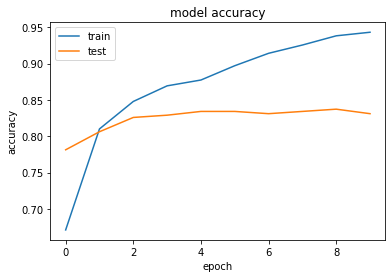

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()


# # This means that our model is overfitting on the training set.
# # Ideally, the performance difference between training and test sets should be minimum.


In [ ]:
# accuracy_score(df_val['label'],(model.predict(glove_df_val)>=0.5).astype('int32'))

ValueError: ignored

### Text Classification with Recurrent Neural Network (LSTM)

In [ ]:
from tensorflow.keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(512))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           1472700   
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,138,237
Trainable params: 1,665,537
Non-trainable params: 1,472,700
_________________________________________________________________
None


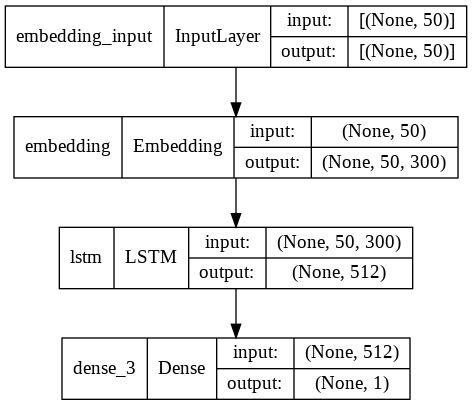

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/10
31/31 [==============================] - 2s 68ms/step - loss: 0.3751 - accuracy: 0.8381 - precision_1: 0.8500 - recall_1: 0.7637 - val_loss: 0.4918 - val_accuracy: 0.8269 - val_precision_1: 0.8151 - val_recall_1: 0.7864
Epoch 2/10
31/31 [==============================] - 2s 59ms/step - loss: 0.4060 - accuracy: 0.8329 - precision_1: 0.8625 - recall_1: 0.7340 - val_loss: 0.4551 - val_accuracy: 0.8135 - val_precision_1: 0.7985 - val_recall_1: 0.7723
Epoch 3/10
31/31 [==============================] - 2s 58ms/step - loss: 0.4975 - accuracy: 0.7808 - precision_1: 0.8104 - recall_1: 0.6496 - val_loss: 0.5437 - val_accuracy: 0.7845 - val_precision_1: 0.8759 - val_recall_1: 0.5962
Epoch 4/10
31/31 [==============================] - 2s 58ms/step - loss: 0.4956 - accuracy: 0.7979 - precision_1: 0.8729 - recall_1: 0.6283 - val_loss: 0.4620 - val_accuracy: 0.7990 - val_precision_1: 0.8766 - val_recall_1: 0.6338
Epoch 5/10
31/31 [==============================] - 2s 59ms/step - loss: 0.4

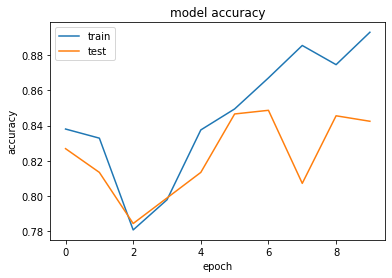

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Precision:", score[2])
print("Test Recall:", score[3])
print("Test F1:", new_f1_score(score[2], score[3]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
accuracy_score(df_val['label'],(model.predict(X_val)>=0.5).astype('int32'))

0.7775

In [ ]:
confusion_matrix(df_val['label'],(model.predict(X_val)>=0.5).astype('int32'))

array([[178,  22],
       [ 67, 133]])

In [ ]:
f1_score(df_val['label'],(model.predict(X_val)>=0.5).astype('int32'))

0.7492957746478874

In [ ]:
#accuracy_score(df_val['label'],model.predict_classes(X_val))

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/df_7k.csv')
df=df[['ein','Org Name','label']]

## BERT

In [ ]:
pip install fastbert

     |████████████████████████████████| 219 kB 5.3 MB/s 


In [ ]:
from fastbert import FastBERT

In [ ]:
X = df['cleaned_text']
y = df['label']
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
labels = [1, 0]
model = FastBERT(
    kernel_name="google_bert_base_en",  # "google_bert_base_zh" for Chinese
    labels=labels,
    seq_length=32,
    device='cuda:0'
)

/root/.fastbert/google_bert_base_en.bin are not exist or md5 is wrong.
Download google_bert_base_en file from http://www.weijieliu.com/download/papers/fastbert/google_bert_base_en.bin
23.9% of 420.06M

In [ ]:
#df_val= pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/val.csv')
#df_val['cleaned_text'] = df_val['name'].apply(lambda x: clean_text(x))

In [ ]:
df_val.shape

(400, 5)

In [ ]:
model.fit(
    X_train.tolist(),
    y_train.tolist(),
    sentences_dev = X_test.tolist(),
    labels_dev = y_test.tolist(),
    finetuning_epochs_num = 5,
    distilling_epochs_num = 5,
    learning_rate = 1e-5,
    model_saving_path='./fastbert.bin',
)

[2021/3/30-20:31:54 FastBERT]:Start Training.
[2021/3/30-20:31:54 FastBERT]:Fine-tuning the backbone for 5 epochs using cuda:0.


/usr/local/lib/python3.7/dist-packages/fastbert/uer/utils/optimizers.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


[2021/3/30-20:32:2 FastBERT]:Fine-tuning epoch 1/5 step 100/301: loss = 0.654
[2021/3/30-20:32:11 FastBERT]:Fine-tuning epoch 1/5 step 200/301: loss = 0.458
[2021/3/30-20:32:19 FastBERT]:Fine-tuning epoch 1/5 step 300/301: loss = 0.398
[2021/3/30-20:32:55 FastBERT]:Evaluating at fine-tuning epoch 1/5 : train_acc = 0.887, dev_acc = 0.853
[2021/3/30-20:32:55 FastBERT]:dev_acc (0.8533554266777134) > best_acc (0.0), saving model to ./fastbert.bin.
[2021/3/30-20:33:5 FastBERT]:Fine-tuning epoch 2/5 step 100/301: loss = 0.308
[2021/3/30-20:33:13 FastBERT]:Fine-tuning epoch 2/5 step 200/301: loss = 0.295
[2021/3/30-20:33:22 FastBERT]:Fine-tuning epoch 2/5 step 300/301: loss = 0.297
[2021/3/30-20:33:57 FastBERT]:Evaluating at fine-tuning epoch 2/5 : train_acc = 0.919, dev_acc = 0.862
[2021/3/30-20:33:57 FastBERT]:dev_acc (0.8624689312344657) > best_acc (0.8533554266777134), saving model to ./fastbert.bin.
[2021/3/30-20:34:7 FastBERT]:Fine-tuning epoch 3/5 step 100/301: loss = 0.200
[2021/3/30-

In [ ]:
# Loading the model and making inference
model.load_model('./fastbert.bin')
label, exec_layers = model('kimochi service center', speed=0.7)

In [ ]:
label

1

In [ ]:
labels = []
for name in X_test.tolist():
  label, exec_layers = model(name, speed=0.7)
  labels.append(label)


In [ ]:
accuracy_score(y_test,labels)

0.8583264291632146

In [ ]:
#validate on the bay area
bay = pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/hold_out.csv')


In [ ]:
bay.head()

,ein,Org Name,label,source
0,770309432,THE@CHURCH IN OUR LORD JESUS CHRIST REVIVAL OU...,0,bay
1,141865897,INTERNATIONAL ANTIOCH MINISTRIES INC,0,bay
2,770544700,LADIES AUXILIARY OF MISSION SANTA CLARA CHARITIES,0,bay
3,946104122,EDWARD L & ADDIE M SOULE FOUNDATION,0,bay
4,770446680,GOLDEN RETRIEVERS IN CYBERSPACE,0,bay


In [ ]:
bay.dropna(subset=['Org Name'],inplace=True)

In [ ]:
bay['cleaned_text'] = bay['Org Name'].apply(lambda x: clean_text(x))

In [ ]:
labels_ca = []
for name in bay['cleaned_text'].tolist():
  label, exec_layers = model(name, speed=0.7)
  labels_ca.append(label)


In [ ]:
confusion_matrix(bay['label'],labels_ca)

array([[186,  14],
       [ 19, 181]])

In [ ]:
accuracy_score(bay['label'],labels_ca)

0.9175

In [ ]:
bay['pred'] = labels_ca

In [ ]:
bay[(bay['label']!=bay['pred'])]

,ein,Org Name,label,source,cleaned_text,pred
6,942581686,KIDANGO INC,0,bay,kidango inc,1
17,431967258,PLACE-2-BE COMMUNITY CENTER,0,bay,placebe community center,1
39,943413477,CALIFORNIA ALLIANCE OF AFRICAN AMERICAN EDUCATORS,0,bay,california alliance of african american educators,1
51,770311831,SAN JOSE MULTICULTURAL ARTISTS GUILD INC,0,bay,san jose multicultural artists guild inc,1
71,237420553,WESTERN REGION PUERTO RICAN COUNCIL,0,bay,western region puerto rican council,1
95,941254641,EASTFIELD MING QUONG INC,0,bay,eastfield ming quong inc,1
96,770160406,FREEDOM WORLDWIDE,0,bay,freedom worldwide,1
128,43718164,VILLAGE HARVEST CORPORATION,0,bay,village harvest corporation,1
133,203036462,AMERICAN FAMILY CHARITY INC,0,bay,american family charity inc,1
156,943212987,LIFE-TORCH BODHI SOCIETY INC,0,bay,lifetorch bodhi society inc,1


### Second Validation

In [ ]:
df_val= pd.read_csv('https://raw.githubusercontent.com/chengren/NPOs/master/val.csv')

In [ ]:
df_val['cleaned_text'] = df_val['name'].apply(lambda x: clean_text(x))

In [ ]:
df_val

,code,name,country,cleaned_text
0,668.0,INDIANS FOR COLLECTIVE ACTION K K JINDAL,INDIAN,indians for collective action jindal
1,756.0,ANANDA MARGA SCHOOL OF THE SOUTH BAY INC,INDIAN,ananda marga school of the south bay inc
2,822.0,ANAMI ASHRAM,INDIAN,anami ashram
3,840.0,SHREE GURUDEV ASHRAM CALIFORNIA INC,INDIAN,shree gurudev ashram california inc
4,865.0,VAJRADHATU,INDIAN,vajradhatu
...,...,...,...,...
530,1694.0,GRUPO DE CARNAVAL CULTURAL PORTUGUES DE SAO JOSE,PORTUGUESE,grupo de carnaval cultural portugues de sao jose
531,1833.0,PORTUGUESE HERITAGE SOCIETY OF CALIFORNIA INC,PORTUGUESE,portuguese heritage society of california inc
532,2394.0,GROUP FOLCLORICO TEMPOS DE OUTRORA,PORTUGUESE,group folclorico tempos de outrora
533,3084.0,PORTUGUESE HERITAGE PUBLICATIONS OF CALIFORNIA...,PORTUGUESE,portuguese heritage publications of california...


In [ ]:
labels_val = []
for name in df_val['cleaned_text'].tolist():
  label, exec_layers = model(name, speed=0.5)
  labels_val.append(label)

In [ ]:
labels_val.count(1)/df_val.shape[0]

0.9439252336448598

In [ ]:
df_val['pred']=labels_val

In [ ]:
df_val['label'] =1

In [ ]:
df_val[(df_val['label']!=df_val['pred'])]

,code,name,country,cleaned_text,pred,label
21,1737.0,LOKENATH DIVINE LIFE FELLOWSHIP,INDIAN,lokenath divine life fellowship,0,1
24,1809.0,NARGIS DUTT CANCER FOUNDATION INC,INDIAN,nargis dutt cancer foundation inc,0,1
60,2570.0,GEETAS CHILD ACADEMY,INDIAN,geetas child academy,0,1
91,3135.0,FRIENDS OF SVCE,INDIAN,friends of svce,0,1
93,3173.0,BITSAA - SILICON VALLEY INC,INDIAN,bitsaa silicon valley inc,0,1
98,3199.0,SOCIETY FOR RURAL IMPROVEMENT,INDIAN,society for rural improvement,0,1
100,3225.0,AUMWARE FOUNDATIONS INC,INDIAN,aumware foundations inc,0,1
106,3293.0,CALIFORNIA CRICKET ACADEMY,INDIAN,california cricket academy,0,1
112,3375.0,TENNISBALL CRICKET ASSOCIATION,INDIAN,tennisball cricket association,0,1
209,3001.0,SAINT TE RELIGIOUS FOUNDATION,CHINESE,saint te religious foundation,0,1
